# Generating Synthetic Order Volume

## Introduction

Understanding real-world sales patterns often requires modeling specific aspects of the data which can be obscured by factors that are of no theoretical interest. For instance, the effects of price sensitivity may be obscured by seasonal patterns, seasonal patterns may be partially obscured by one-off events, effects of consumer confidence, or by long-term trends, among others. By constructing a synthetic dataset with well-defined components, we can test whether a model can effectively recover these hidden relationshop.

This notebook creates synthetic sales data for an online store and explains the logic behind its generation. The goal is to simulate a realistic sales time series incorporating latent seasonality (both weekly and yearly), latent growth over time, as well as influences of unmodeled factors via a random walk.
The generated data can be used for testing time series models that aim to uncover some of these latent structures.

Key aspects of our data:

- **Latent Growth.** Sales increase gradually, accelerating after a certain point, and then saturate.
- **Yearly Seasonality.** Sales vary throughout the year, with a peak during certain periods (e.g., summer or holiday seasons).
- **Weekly Seasonality.** A periodic pattern emerges within each week (e.g., higher sales on weekends).
- **Random Walk Noise.** Unmodeled variations and external shocks are captured through a random walk process, ensuring realistic fluctuations.

## 1. Import Required Libraries And Define Functions

In [20]:
import polars as pl
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme_bw, scale_x_continuous, scale_x_discrete, scale_x_datetime

In [ ]:
# Creates a simple plot using plotnine
def plot_function(x, y, title, xlab, ylab):
    # Convert x to numpy array
    x = np.array(x)
    
    # Check if y is a callable function
    if callable(y):
        # If y is a function, apply it to x and create a DataFrame
        df = pd.DataFrame({"x": x, "y": y(x)})
    else:
        # If y is not a function, create a DataFrame directly
        df = pd.DataFrame({"x": x, "y": y})        

    # Create the plot using ggplot
    plot = (ggplot(df, aes(x="x", y="y")) + geom_line() + labs(title=title, x=xlab, y=ylab) + theme_bw())
    
    # Return the plot
    return plot

## 2. Data Generation Process

In the initial steps, we will create a number of independent components that contribute to the price independently. In principle, the way to interpret them is 'this is what sales would look like over the time frame considered is all else remained equal'.

### 2.1. Create the Time Series

A daily time series is generated starting from June 1, 2021, up to the present day. This ensures sufficient data points to analyze trends and seasonality.

In [22]:
# set the random seed
np.random.seed(42)

# define date range
start_date = "2021-06-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# generate time index
days_since_start = np.arange(len(date_range))

### 2.2. Long-Term Growth Curve

Long-term sales growth is modeled as a modified logistic function, representing an initial slow growth phase, followed by acceleration, and eventual saturation. This function ensures that sales begin near zero, increase slowly at first, then accelerate before stabilizing.

$ f(t)  = L \cdot (1 + exp(-k \cdot (t - t_0)))^{(-1/v)} $

Parameters:
- **L.** Upper bound on sales (saturation level).
- **k.** Growth rate.
- **x_0.** Inflection point (where acceleration peaks).
- **v.** Asymmetry parameter (v < 1 slower growth to the right of **x0**, 0 < v < 1 slower growth to the left of **x0**)

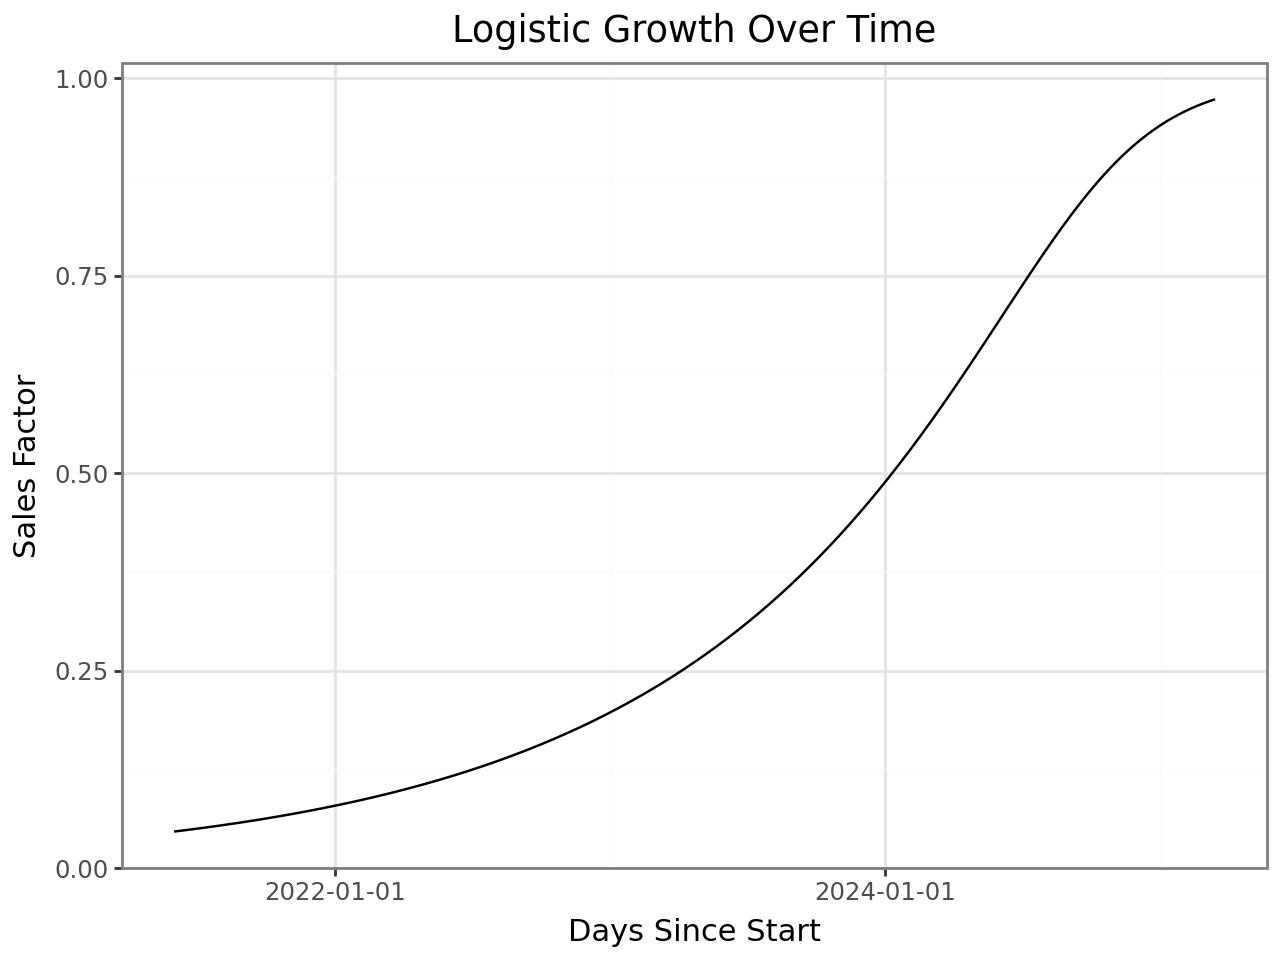

In [30]:
# Logistic function parameters
L = 1      # Upper saturation limit
k = 0.0125 # Growth rate
t0 = 1100  # Inflection point
v = 5      # Asymmetry parameter (v > 1 shifts right, 0 < v < 1 shifts left)

# Compute the logistic growth curve
growth_fn = lambda t: L * (1 + v * np.exp(-k * (t - t0)))**(-1/v)
growth = growth_fn(days_since_start)

plot_function(x=date_range, y=growth, title="Logistic Growth Over Time", xlab="Days Since Start", ylab="Sales Factor")

### 2.3. Yearly Seasonal Pattern

Yearly seasonality is introduced using a scaled cosine transformations of the day of the year. This captures periodic effects such as, in this case, increased summer sales. This function is scaled to oscillate between 0.8 and 1.2 over the course of a year, which, when multiplied with the average sales function futher down will decrease winter sales by up to $20\%$, and increase summer sales by up to $20\%$.

In [5]:
# Yearly seasonality
yearly_seasonality_fn = lambda day: 1 + 0.2 * np.cos(2 * np.pi * day / 365.25 - np.pi)
yearly_seasonality = yearly_seasonality_fn(date_range.day_of_year)

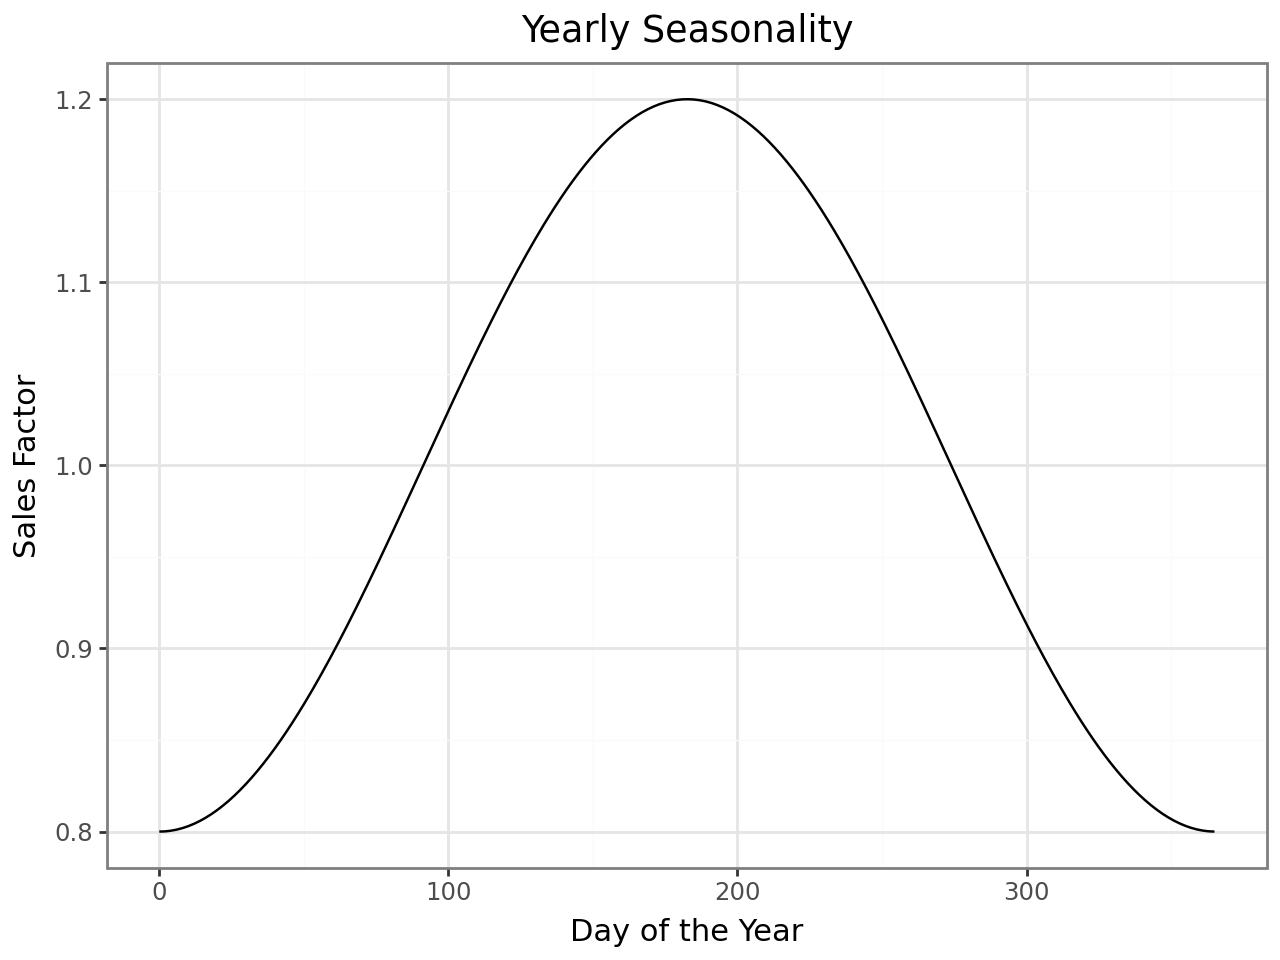

In [29]:
plot_function(x=range(0,366), y=yearly_seasonality_fn, title="Yearly Seasonality", xlab="Day of the Year", ylab="Sales Factor")

### 2.4. Weekly Seasonal Pattern

Weekly seasonality is also modeled a scaled cosine transformations of the day of the week. In this case, we model a drop in sales, primarily on Thursday-Friday. This function is scaled to oscillate between 0.9 and 1.1 over the course of the week, which, when multiplied with the average sales function futher will change sales by $\pm 10\%$.

In [7]:
# Weekly seasonality
weekly_seasonality_fn = lambda day: 1 + 0.1 * np.cos(2 * np.pi * day / 7)
weekly_seasonality = weekly_seasonality_fn(date_range.day_of_year)

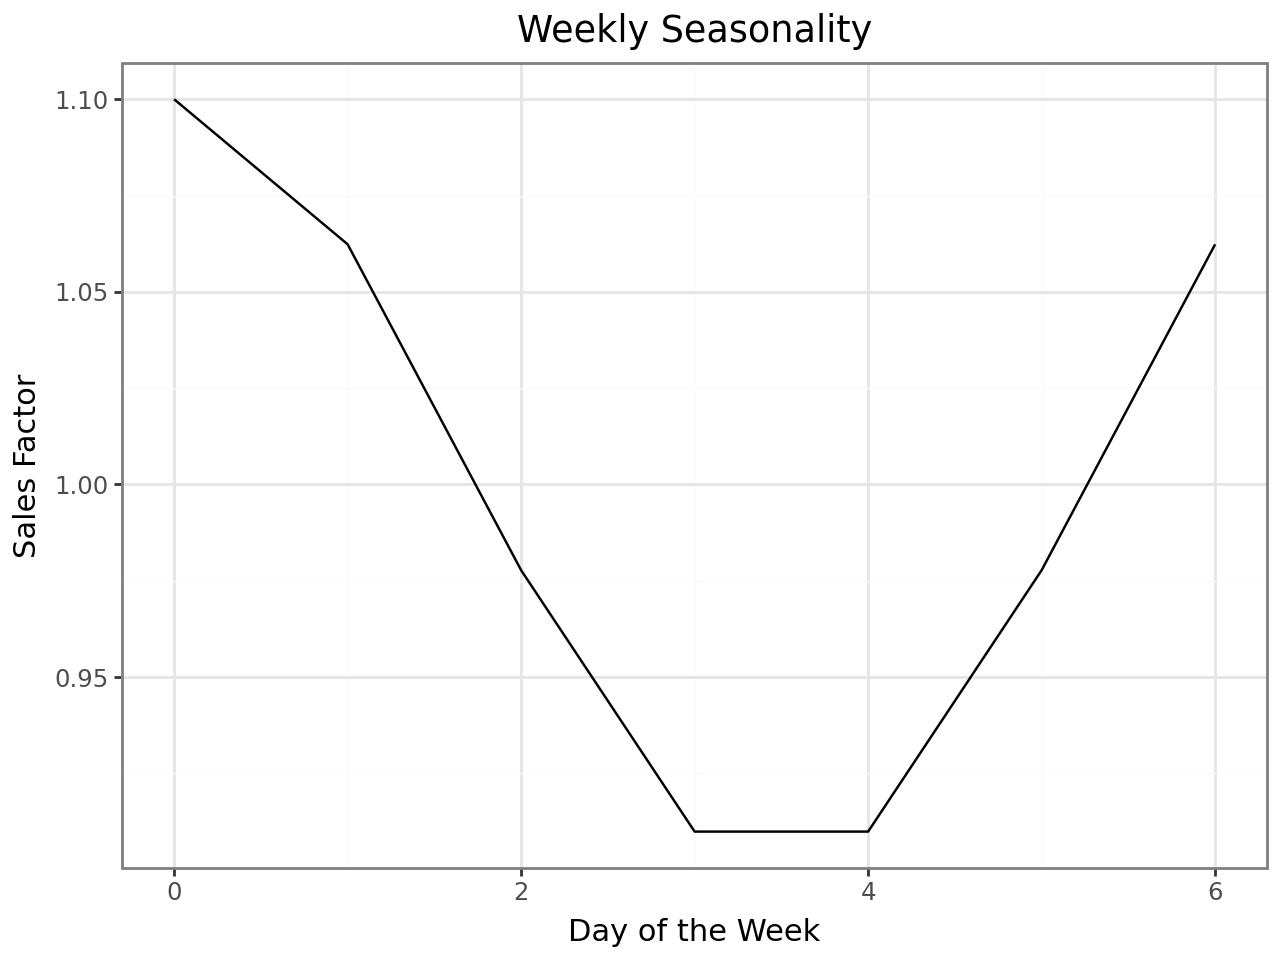

In [28]:
plot_function(x=range(0,7), y=weekly_seasonality_fn, title="Weekly Seasonality", xlab="Day of the Week", ylab="Sales Factor")

### 2.5. Combining Growth and Seasonality

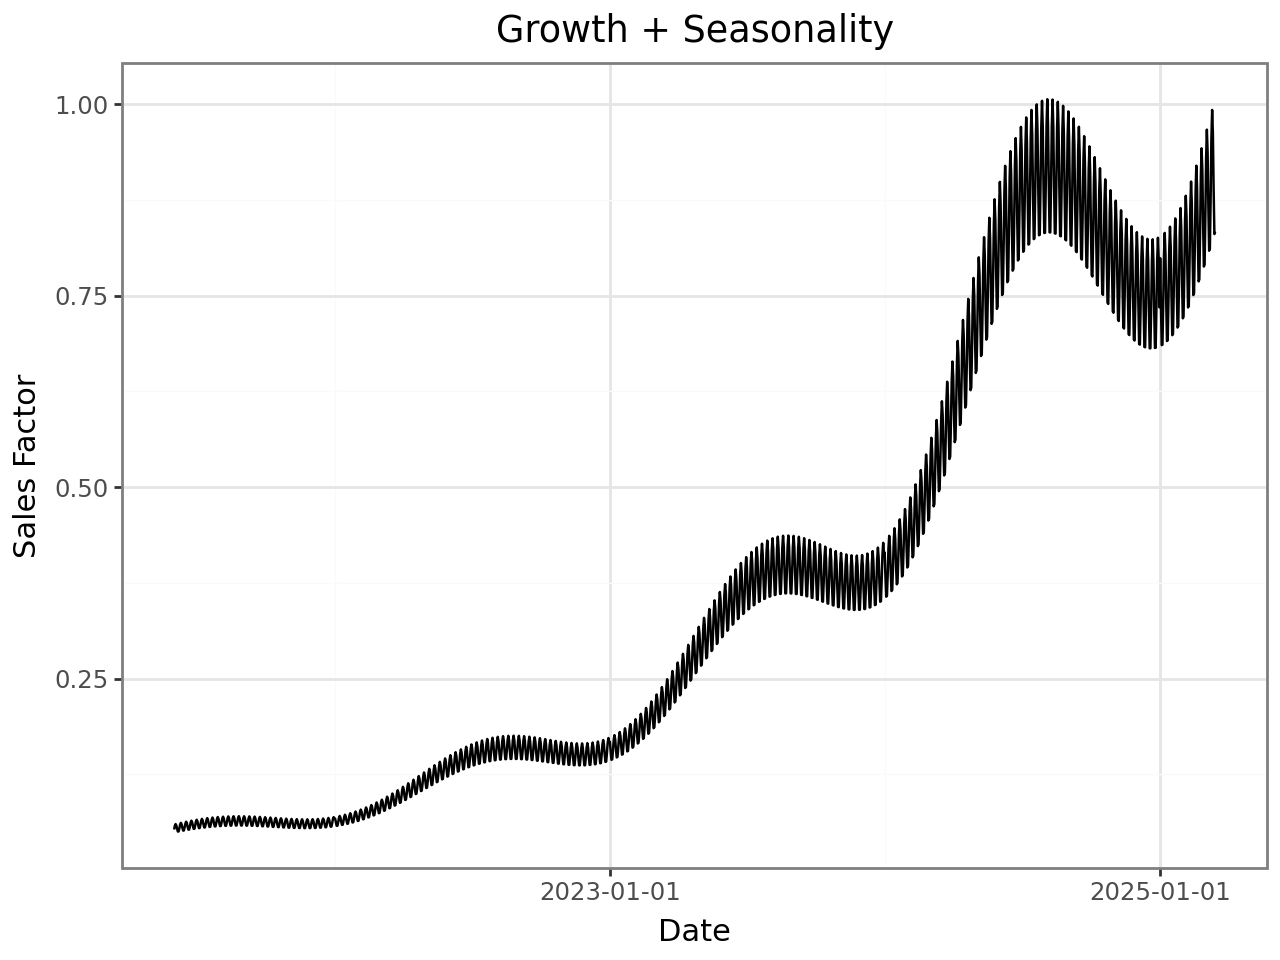

In [27]:
sales = np.array(growth) * np.array( yearly_seasonality ) * np.array( weekly_seasonality )
breaks = [pd.Timestamp(d) for d in ["2017-01-01", "2019-01-01", "2021-01-01", "2023-01-01", "2025-01-01"]]
plot_function(x=date_range, y=sales, title="Growth + Seasonality", xlab="Date", ylab="Sales Factor") + scale_x_datetime(breaks = breaks)

### 2.6. Random Walk: Unmodeled Influences and External Shocks

A random walk is used to simulate external influences and unpredictable variations. This component accounts for factors not explicitly modeled, such as promotions, economic shifts, or changes in popularity, or influences of competitors. The random walk is centered (mean zero) to ensure it does not systematically bias the trend. This ensures that the long-term sales trajectory remains driven by the logistic growth component rather than arbitrary drift. This does not amount to any sort of assumption about the data-generating process in a more realistic scenario. This is done strictly to maintain interpretability in the bringing together of the different parts of the synthetic demand.

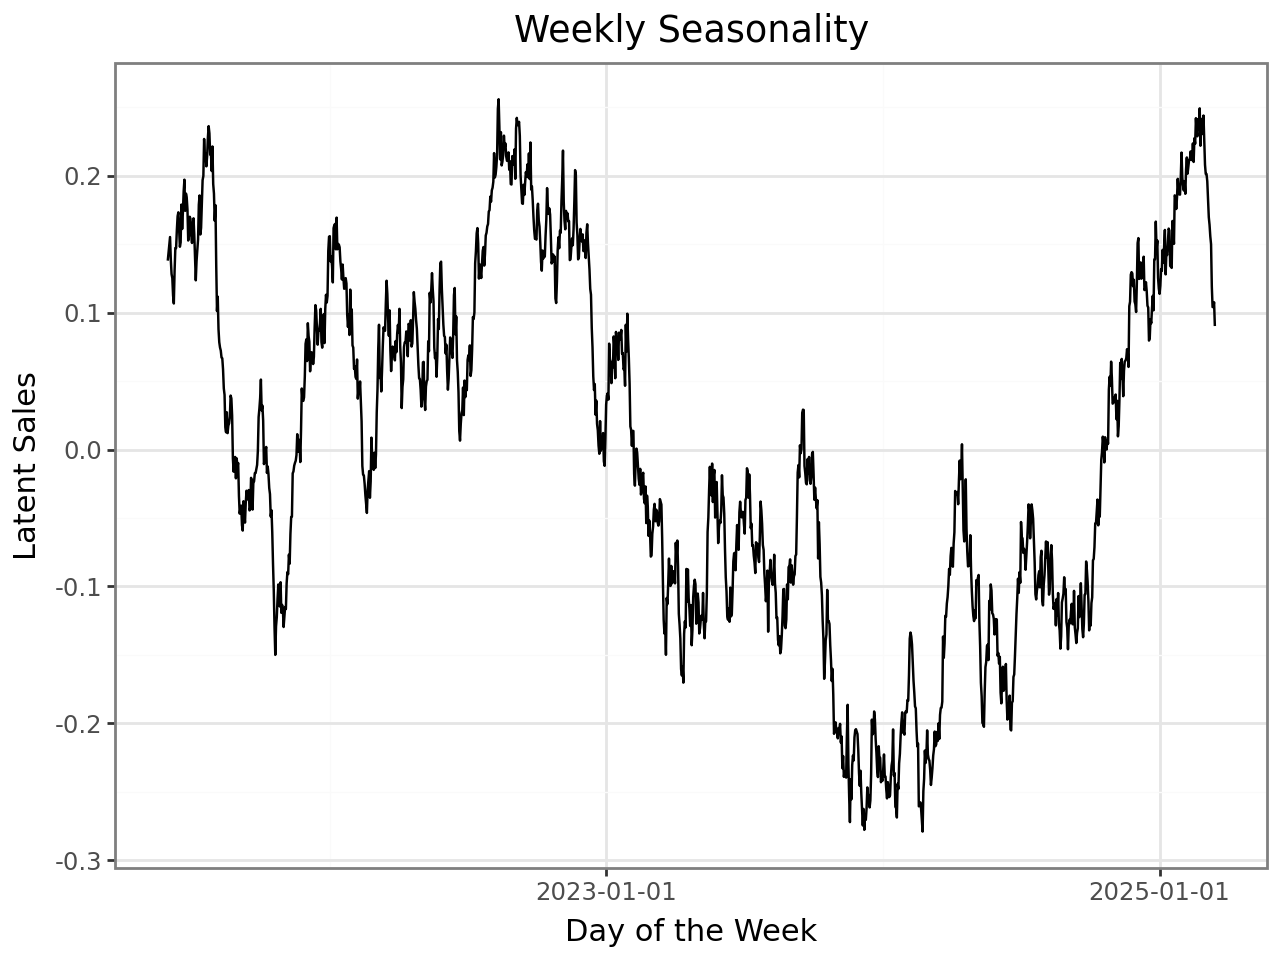

In [ ]:
np.random.seed(441)

random_walk = np.cumsum(np.random.normal(scale=.015, size=len(date_range)))
centered_random_walk = random_walk - np.mean(random_walk)

plot_function(x=date_range, y = centered_random_walk, title="Random Walk Component", xlab="Date", ylab="Latent Sales") + scale_x_datetime(breaks = breaks)

Let's visualize the growth together with the random walk for future reference, because they will be estimated as one component in the model in the next notebook.

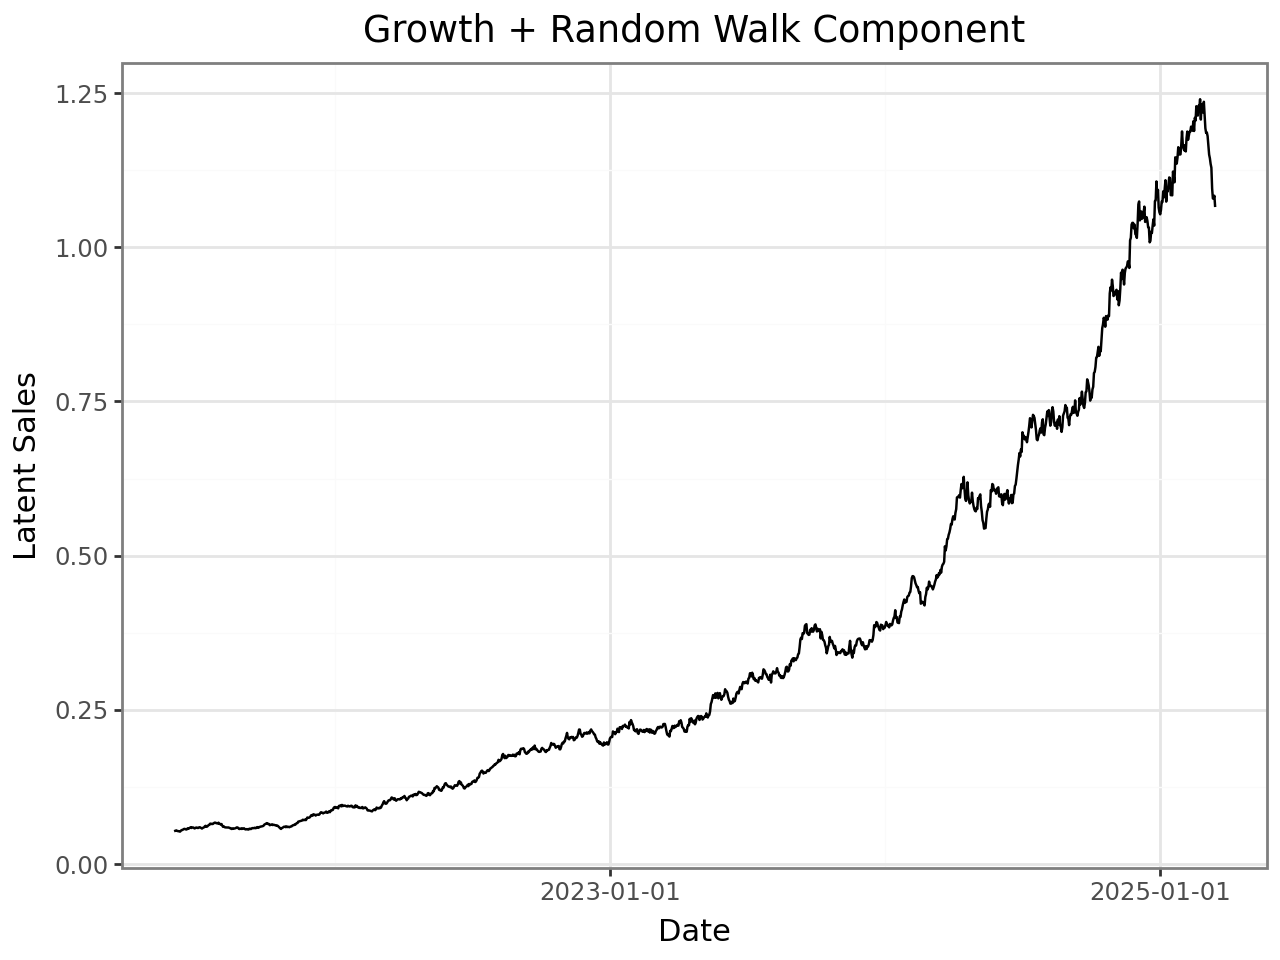

In [32]:
growth_plus_rw = np.exp( np.log(growth) + centered_random_walk)
plot_function(x=date_range, y = growth_plus_rw, title="Growth + Random Walk Component", xlab="Date", ylab="Latent Sales") + scale_x_datetime(breaks = breaks)

The random walk is combined with the sales pattern created so far in log-space in order to ensure that the effects are multiplicative. This aligns with real-world sales data, where sales fluctuations are typically proportional rather than absolute. This is also a simple way of preventing sales from dropping below 0.

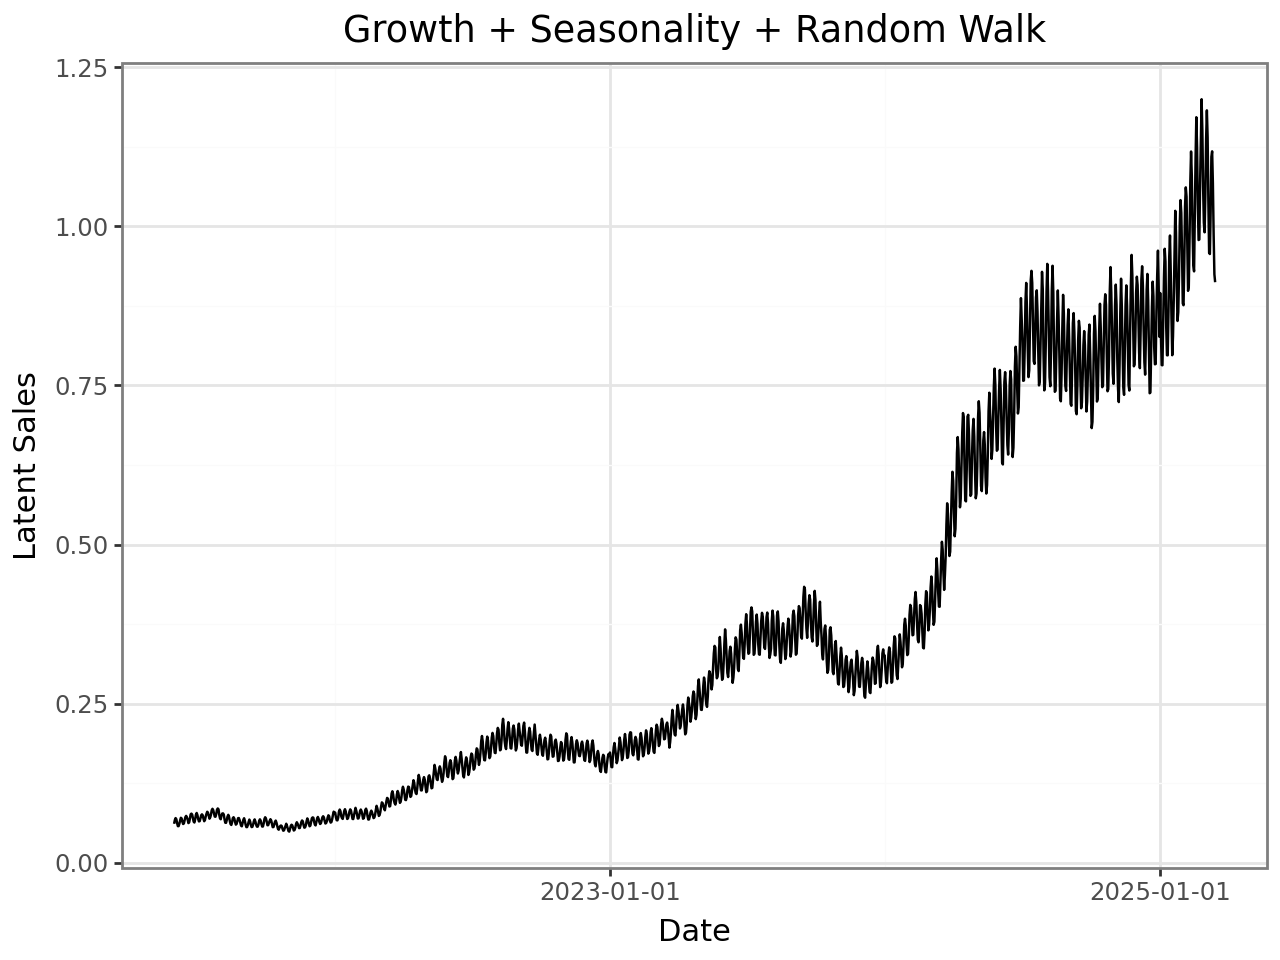

In [35]:
sales_with_random_component = np.exp( np.log(sales) + centered_random_walk)
plot_function(x=date_range, y = sales_with_random_component, title="Growth + Seasonality + Random Walk", xlab="Date", ylab="Latent Sales") + scale_x_datetime(breaks = breaks)

### 2.7. Effect of Price 

In [12]:
def sample_log_price_change(n, p, min_delta, max_delta):
    """Sample n values from a mixture of:
    - 0 with probability p
    - Uniform(min_delta, max_delta) with probability (1-p)
    """
    zero_mask = np.random.rand(n) < p  # Boolean mask for zeros
    delta_log_price_nonzero = np.random.uniform(min_delta, max_delta, n)  # Sample from Uniform(a, b)
    
    # Combine: replace values with 0 where zero_mask is True
    delta_log_price = np.where(zero_mask, 0, delta_log_price_nonzero)
    return delta_log_price

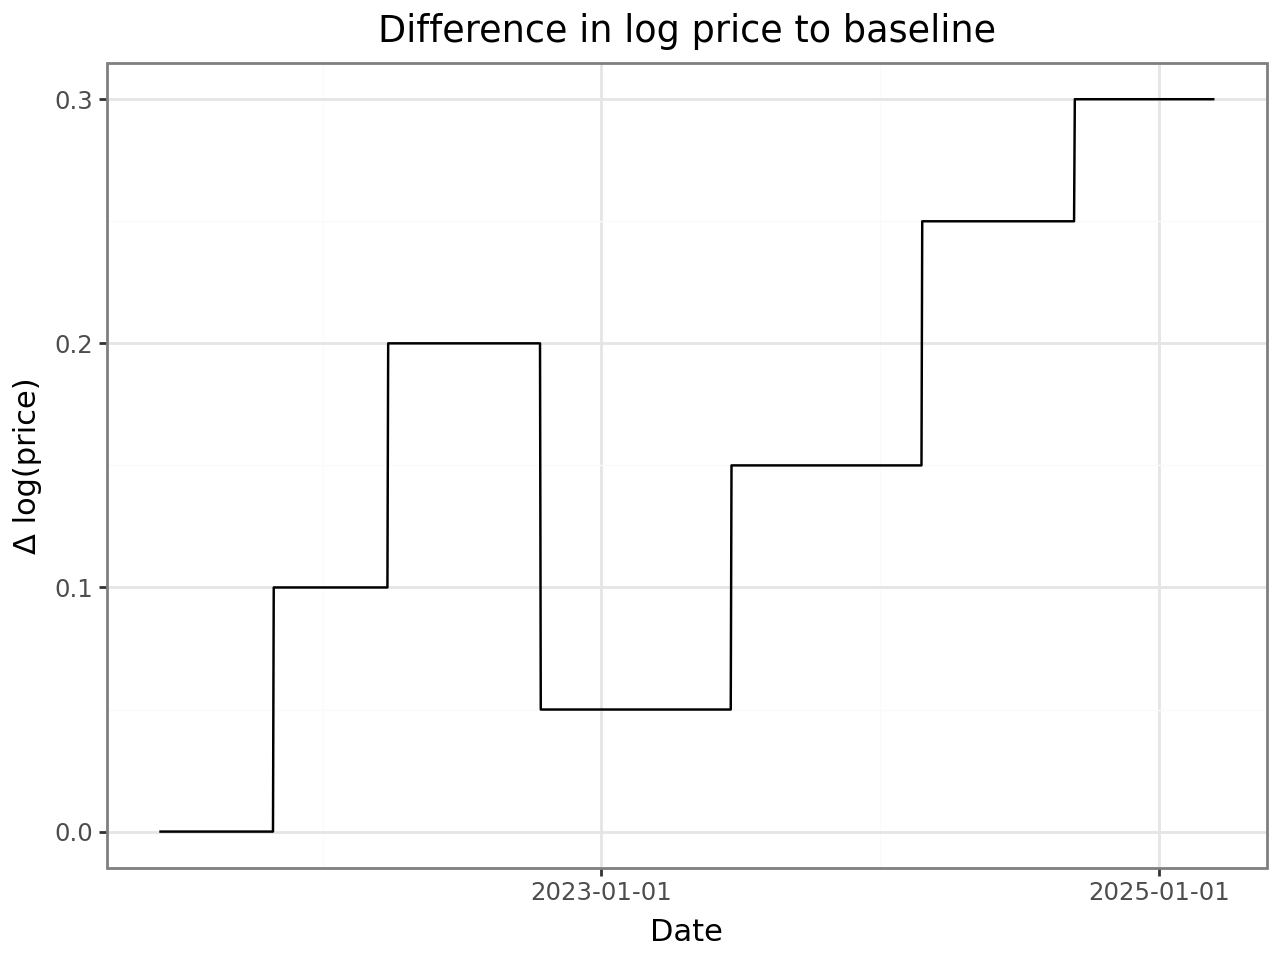

In [33]:
delta_log_price = [0.0]*len(date_range)
delta_log_price[150] = .1
delta_log_price[300] = .1
delta_log_price[500] = -.15
delta_log_price[750] = .1
delta_log_price[1000] = .1
delta_log_price[1200] = .05
plot_function(x=date_range, y = np.cumsum(delta_log_price), title="Difference in log price to baseline", xlab="Date", ylab="Δ log(price)") + scale_x_datetime(breaks = breaks)

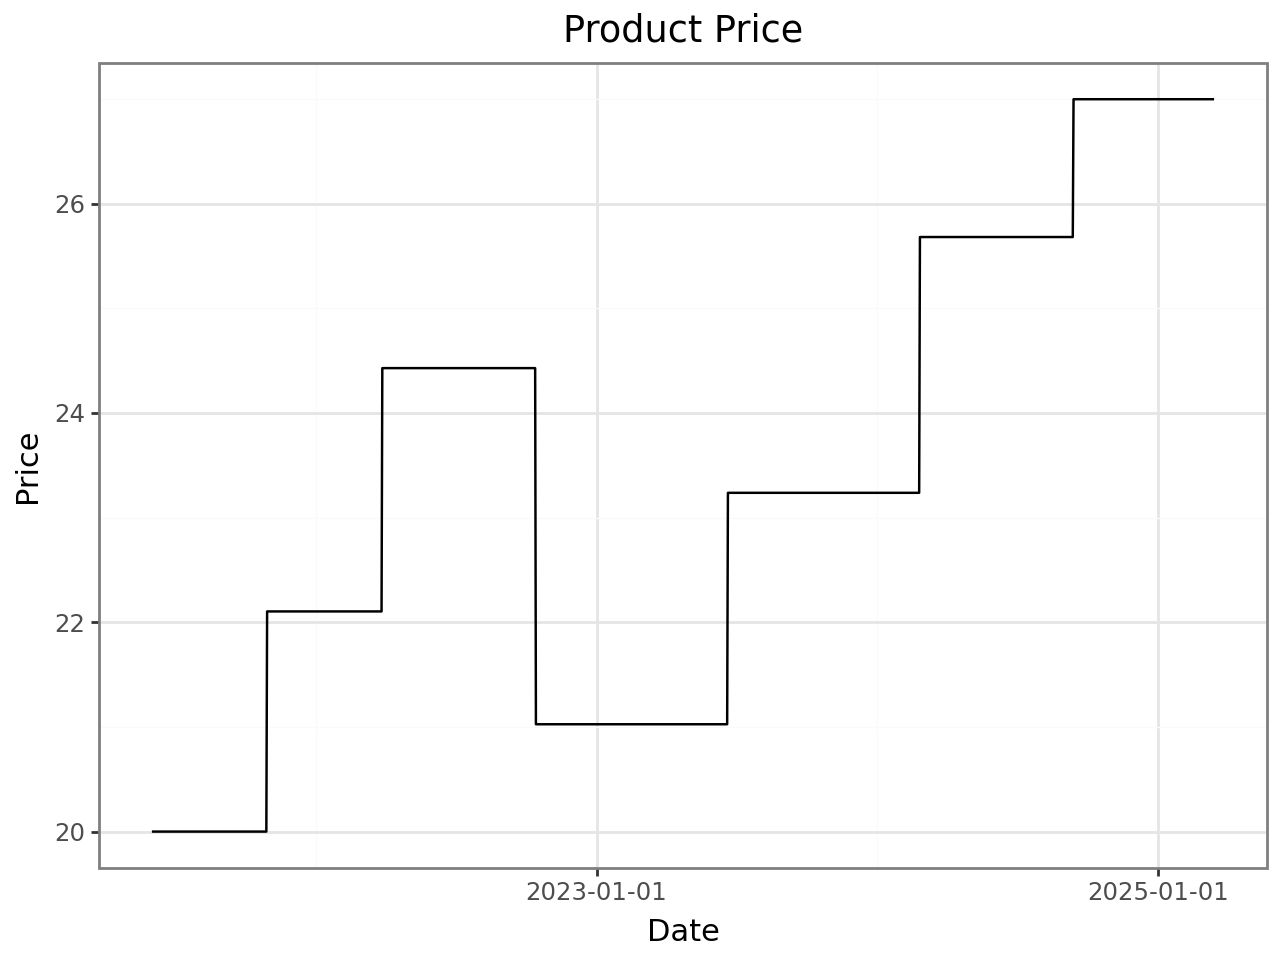

In [14]:
price_base = 20
log_price = np.log(price_base) + np.cumsum(delta_log_price)

plot_function(x=date_range, y = np.exp( log_price ), title="Product Price", xlab="Date", ylab="Price") + scale_x_datetime(breaks = breaks)

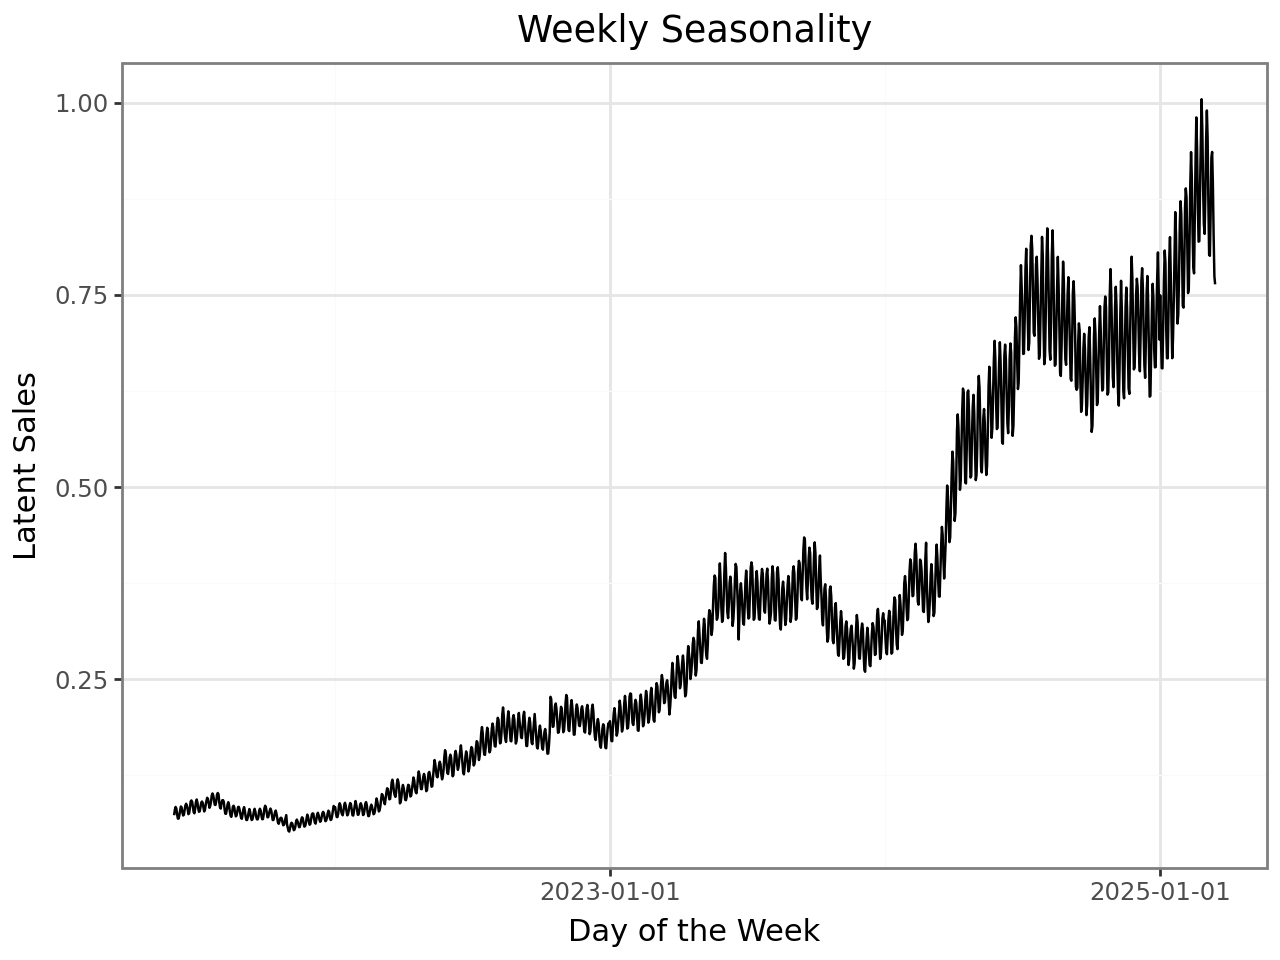

In [15]:
elasticity = -1.2
sales_with_price_effect = np.exp( np.log(sales_with_random_component) + elasticity * (log_price - np.mean(log_price)) )
plot_function(x=date_range, y = sales_with_price_effect, title="Weekly Seasonality", xlab="Day of the Week", ylab="Latent Sales") + scale_x_datetime(breaks = breaks)

### 2.8. Scaled Sales

At this point, we scale the expected sales to a more realistic range for actual sales. 

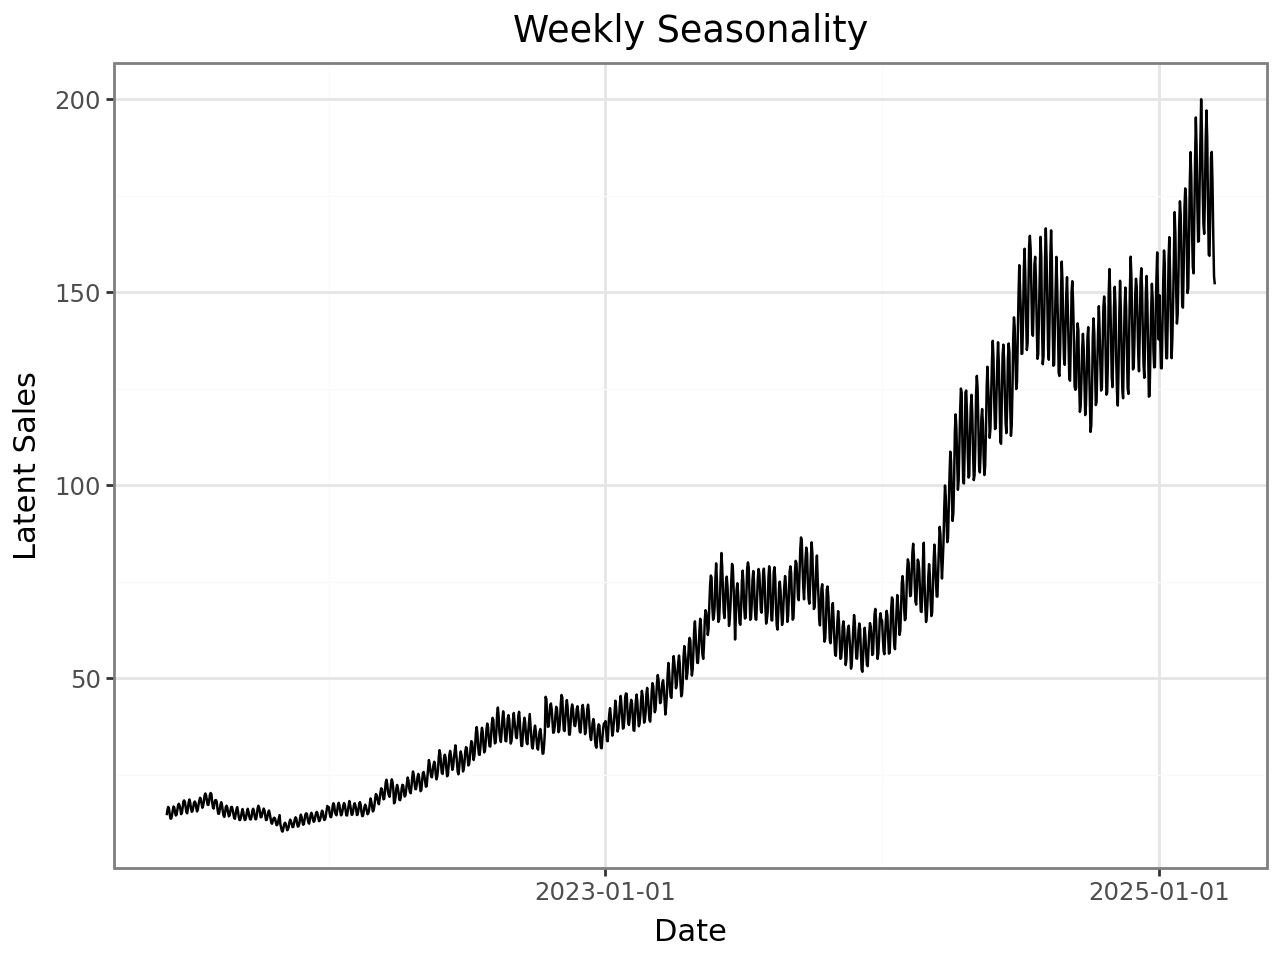

In [16]:
max_sales = 200 # scale the sales to a more realistic range
sales_scaled = max_sales * sales_with_price_effect / sales_with_price_effect.max()

plot_function(x=date_range, y = sales_scaled, title="Weekly Seasonality", xlab="Date", ylab="Latent Sales") + scale_x_datetime(breaks = breaks)

## 3. Realized Sales

What we constructed until now are the expected sales $\lambda$ for each day. We realize them for each day $i$ by drawing them from a Poisson distribution with parameter $\lambda_i$. This approach ensures that while the underlying sales structure is generated smoothly, the final dataset exhibits realistic integer sales values with appropriate stochastic variation.

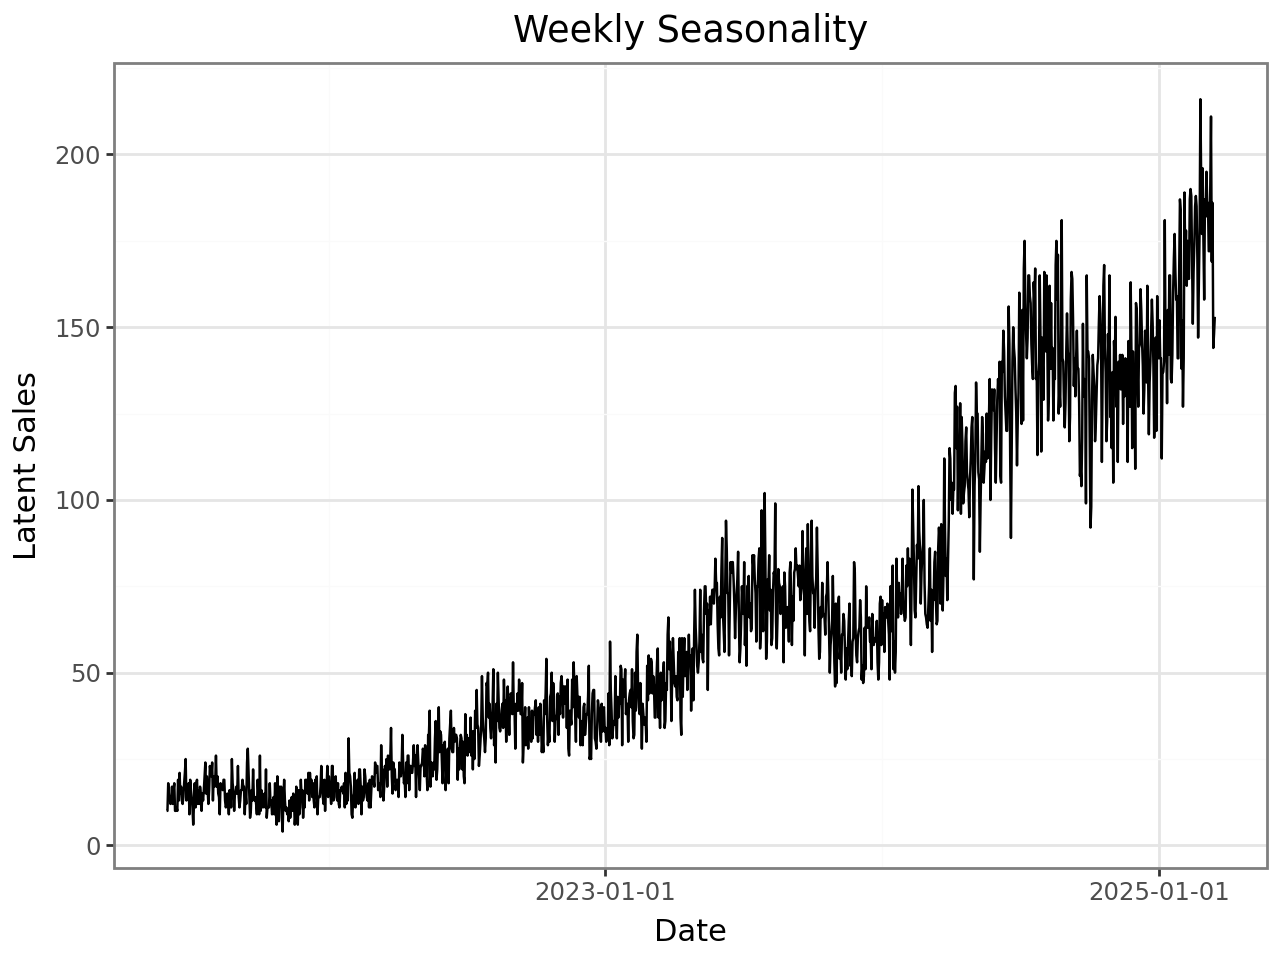

In [17]:
sales_realized = np.random.poisson(lam=sales_scaled)
plot_function(x=date_range, y = sales_realized, title="Weekly Seasonality", xlab="Date", ylab="Latent Sales") + scale_x_datetime(breaks = breaks)

## 4. Sanity-Check

Here, we check that the composition of the sales time series is as expected. We'll estimate regression coefficients for all the components. All should be 1, with the exception of the effect of price, which should equal the specified elastictiy. Please note though, that although all components are additive in log-space, their contributions are not equal, since they are scaled differently.

In [18]:
import statsmodels.api as sm

# fit poisson glm
X = pd.DataFrame({
    'intercept': np.ones(len(date_range)),  # Intercept
    'centered_random_walk': centered_random_walk,
    'weekly_seasonality': np.log(weekly_seasonality),
    'yearly_seasonality': np.log(yearly_seasonality),
    'growth': np.log(growth),
    'log_price': log_price
})

y = sales_realized
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1384
Model:                            GLM   Df Residuals:                     1378
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4654.7
Date:                Sat, 15 Mar 2025   Deviance:                       1390.1
Time:                        09:51:53   Pearson chi2:                 1.38e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                8.9126      0.242     36.821      0.000       8.438       9.387
centered_random_walk     0.9636      0.030     31.949      0.000       0.904       1.023
weekly_seasonality       1.0425      0.047     22.268      0.000       0.951       1.134
yearly_seasonality       0.9664      0.025     37.905      0.000       0.916       1.016
growth                   0.9958      0.009    111.520      0.000       0.978       1.013
log_price               -1.1516      0.074    -15.634      0.000      -1.296      -1.007
========================================================================================
"""

## 5. Save Sales

Having instantiated the sales time series, we save the latent and realized sales in CSV format.

In [19]:
df = pl.DataFrame({
    "date": date_range.astype(str).tolist(),
    "log_price": log_price,  
    "sales_latent": sales_scaled,
    "sales": sales_realized
})
df.write_csv("sales_synthetic.csv")
